# Step 1

Dossier images existe : True
Fichier labels existe : True

--- Chargement des données ---
✅ Chargement réussi ! Total images valides : 90000
     filename  target  gender
0  000000.jpg      -1      -1
1  000001.jpg       1      -1
2  000002.jpg      -1      -1
3  000003.jpg      -1       1
4  000004.jpg       1       1

--- Distribution Croisée (Genre x Target) ---


,Target -1,Target 1
Femmes (-1),40005,13033
Hommes (1),32516,4446


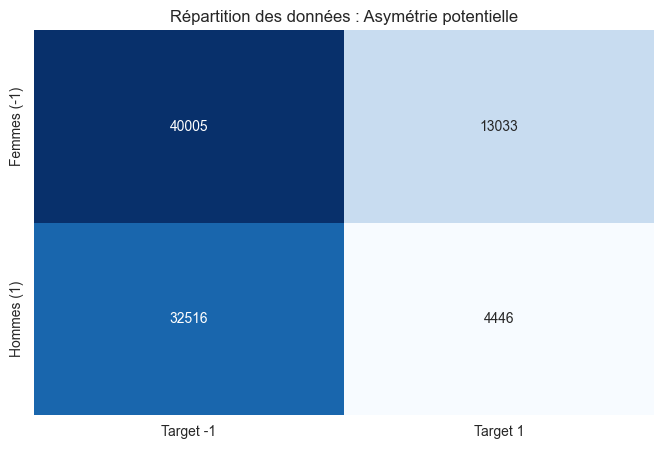


--- Visualisation des échantillons ---


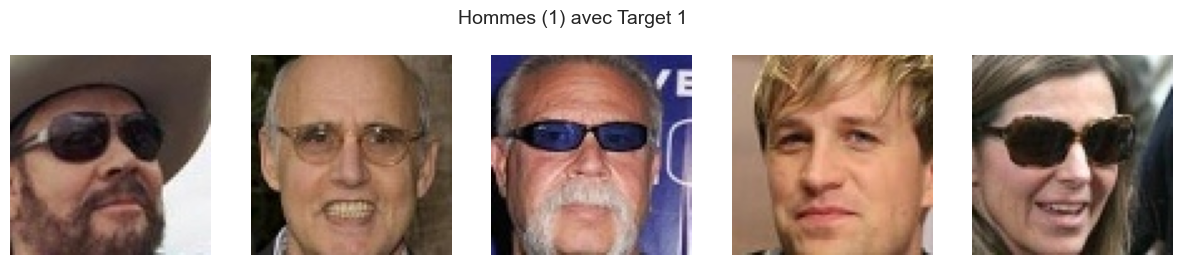

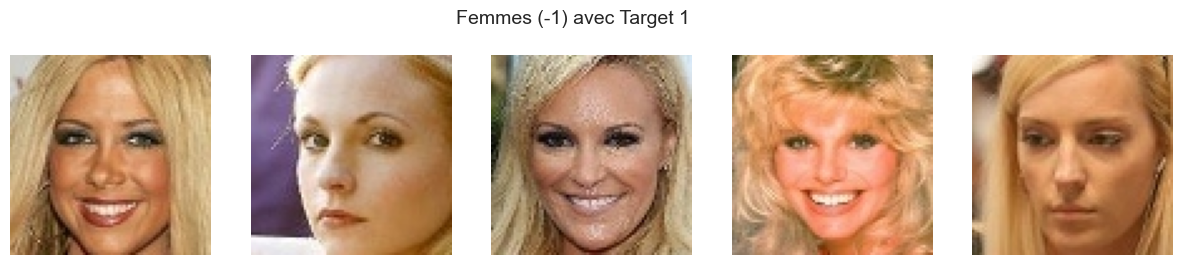


--- Split Terminé ---
Train Set : 72000 images
Val Set   : 18000 images


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# ==========================================
# 1. CONFIGURATION DES CHEMINS
# ==========================================
# Adaptez ces chemins selon votre dossier (ex: sur Colab: '/content/drive/...')
TRAIN_DIR = './train'        # Dossier contenant les 90 000 images
LABELS_PATH = './train.txt'  # Fichier texte des labels

print(f"Dossier images existe : {os.path.exists(TRAIN_DIR)}")
print(f"Fichier labels existe : {os.path.exists(LABELS_PATH)}")

# ==========================================
# 2. CHARGEMENT ET NETTOYAGE DES LABELS
# ==========================================
print("\n--- Chargement des données ---")
try:
    # Utilisation de regex separator (r"\s+") pour gérer les espaces multiples
    # engine='python' est plus stable pour ce type de fichier
    df = pd.read_csv(LABELS_PATH, sep=r"\s+", names=['filename', 'target', 'gender'], engine='python')

    # Détection et suppression des lignes malformées (NaN)
    nan_count = df.isna().sum().sum()
    if nan_count > 0:
        print(f"⚠️ Attention : {nan_count} valeurs manquantes supprimées.")
        df = df.dropna()

    # Conversion explicite en entiers
    df['target'] = df['target'].astype(int)
    df['gender'] = df['gender'].astype(int)

    print(f"✅ Chargement réussi ! Total images valides : {len(df)}")
    print(df.head())

except Exception as e:
    print(f"❌ Erreur critique : {e}")
    raise

# ==========================================
# 3. ANALYSE DE L'ASYMÉTRIE (Déséquilibre)
# ==========================================
# Cette étape répond à la question : "Est-ce que l'asymétrie est un problème ?" [cite: 28]

# Table de contingence : Combien d'Hommes/Femmes pour chaque Target ?
cross_tab = pd.crosstab(df['gender'], df['target'])
cross_tab.index = ['Femmes (-1)', 'Hommes (1)']
cross_tab.columns = ['Target -1', 'Target 1']

print("\n--- Distribution Croisée (Genre x Target) ---")
display(cross_tab)

# Visualisation
plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Répartition des données : Asymétrie potentielle")
plt.show()

# ==========================================
# 4. VISUALISATION DES IMAGES "SOFTBIO"
# ==========================================
# Pour comprendre ce que le modèle doit chercher (chapeau, lunettes, etc.)

def show_examples(df, folder, target, gender, title, n=5):
    subset = df[(df['target'] == target) & (df['gender'] == gender)]
    if len(subset) == 0: return

    samples = subset.sample(min(n, len(subset)))

    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=14)
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(folder, row['filename'])
        try:
            img = Image.open(img_path)
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.axis('off')
        except:
            pass
    plt.show()

print("\n--- Visualisation des échantillons ---")
show_examples(df, TRAIN_DIR, target=1, gender=1, title="Hommes (1) avec Target 1")
show_examples(df, TRAIN_DIR, target=1, gender=-1, title="Femmes (-1) avec Target 1")
# Astuce : Regardez les points communs (ex: sourires, lunettes, frange ?)

# ==========================================
# 5. SPLIT TRAIN / VALIDATION (Stratifié)
# ==========================================
# On crée un jeu de validation qui a EXACTEMENT la même proportion
# de femmes/hommes/targets que le jeu d'entrainement.

# Création d'une colonne temporaire combinant les deux labels pour stratifier
df['stratify_col'] = df['target'].astype(str) + "_" + df['gender'].astype(str)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,       # 20% pour valider (18 000 images)
    random_state=42,     # Reproductibilité
    stratify=df['stratify_col'] # Stratification double
)

# Nettoyage
train_df = train_df.drop(columns=['stratify_col'])
val_df = val_df.drop(columns=['stratify_col'])

print("\n--- Split Terminé ---")
print(f"Train Set : {len(train_df)} images")
print(f"Val Set   : {len(val_df)} images")

# Step 2

Analyse sur 72000 images d'entraînement.

--- 1. Déséquilibre TARGET (-1 vs 1) ---
Négatifs (-1) : 58017 (80.6%)
Positifs ( 1) : 13983 (19.4%)
👉 Recommandation pos_weight : 4.1491
⚠️ ALERTE : Déséquilibre significatif détecté sur la Target !

--- 2. Déséquilibre GENRE (Femmes vs Hommes) ---
Femmes (-1) : 42430 (58.9%)
Hommes ( 1) : 29570 (41.1%)
⚠️ ALERTE : La base contient 0.7x plus d'un genre que l'autre.
   Cela risque de biaiser la métrique ESIEA.

--- 3. Intersection (Target x Genre) ---


,Target -1,Target 1
Femmes,32004,10426
Hommes,26013,3557


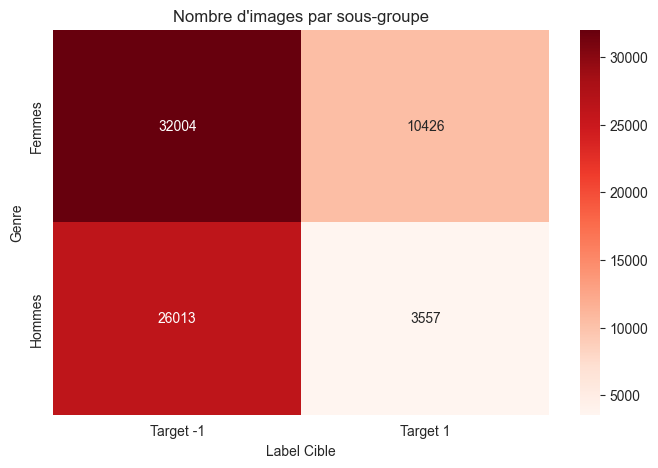

Le groupe majoritaire est 9.0x plus grand que le minoritaire.
🚨 DANGER : Il y a un sous-groupe très minoritaire (voir case la plus claire).
   Le modèle va avoir beaucoup de mal à apprendre sur ce groupe spécifique.


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# On s'assure que train_df est chargé (sinon on le recharge)
if 'train_df' not in locals():
    # Recharge rapide si besoin
    df = pd.read_csv('./train.txt', sep=r"\s+", names=['filename', 'target', 'gender'], engine='python')
    df = df.dropna()
    from sklearn.model_selection import train_test_split
    df['stratify_col'] = df['target'].astype(str) + "_" + df['gender'].astype(str)
    train_df, _ = train_test_split(df, test_size=0.2, stratify=df['stratify_col'], random_state=42)

print(f"Analyse sur {len(train_df)} images d'entraînement.\n")

# ==========================================
# 1. ANALYSE DU TARGET (Le Label à prédire)
# ==========================================
target_counts = train_df['target'].value_counts().sort_index()
neg_count = target_counts.get(-1, 0) # Label -1 (ou 0 selon mapping)
pos_count = target_counts.get(1, 0)  # Label 1

print("--- 1. Déséquilibre TARGET (-1 vs 1) ---")
print(f"Négatifs (-1) : {neg_count} ({neg_count/len(train_df):.1%})")
print(f"Positifs ( 1) : {pos_count} ({pos_count/len(train_df):.1%})")

# Calcul du pos_weight théorique
# Si on a beaucoup de négatifs, le poids doit être > 1 pour booster les positifs
if pos_count > 0:
    recommended_pos_weight = neg_count / pos_count
    print(f"👉 Recommandation pos_weight : {recommended_pos_weight:.4f}")
    if recommended_pos_weight > 1.5 or recommended_pos_weight < 0.6:
        print("⚠️ ALERTE : Déséquilibre significatif détecté sur la Target !")
    else:
        print("✅ Target relativement équilibrée.")
else:
    print("❌ Erreur : Aucun positif trouvé !")

# ==========================================
# 2. ANALYSE DU GENRE (Pour l'équité)
# ==========================================
gender_counts = train_df['gender'].value_counts().sort_index()
fem_count = gender_counts.get(-1, 0)
hom_count = gender_counts.get(1, 0)

print("\n--- 2. Déséquilibre GENRE (Femmes vs Hommes) ---")
print(f"Femmes (-1) : {fem_count} ({fem_count/len(train_df):.1%})")
print(f"Hommes ( 1) : {hom_count} ({hom_count/len(train_df):.1%})")

ratio_gender = hom_count / fem_count if fem_count > 0 else 0
if ratio_gender > 1.2 or ratio_gender < 0.8:
    print(f"⚠️ ALERTE : La base contient {ratio_gender:.1f}x plus d'un genre que l'autre.")
    print("   Cela risque de biaiser la métrique ESIEA.")
else:
    print("✅ Genre relativement équilibré.")

# ==========================================
# 3. L'INTERSECTION CRITIQUE (Le vrai danger)
# ==========================================
print("\n--- 3. Intersection (Target x Genre) ---")
cross_tab = pd.crosstab(train_df['gender'], train_df['target'])
cross_tab.index = ['Femmes', 'Hommes']
cross_tab.columns = ['Target -1', 'Target 1']

display(cross_tab)

# Visualisation Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Reds')
plt.title("Nombre d'images par sous-groupe")
plt.ylabel("Genre")
plt.xlabel("Label Cible")
plt.show()

# Détection du groupe minoritaire extrême
min_val = cross_tab.min().min()
max_val = cross_tab.max().max()
imbalance_ratio = max_val / min_val

print(f"Le groupe majoritaire est {imbalance_ratio:.1f}x plus grand que le minoritaire.")
if imbalance_ratio > 3:
    print("🚨 DANGER : Il y a un sous-groupe très minoritaire (voir case la plus claire).")
    print("   Le modèle va avoir beaucoup de mal à apprendre sur ce groupe spécifique.")

# Step 3

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION
# ==========================================
BEST_PARAMS = {
    "lr": 0.0008043319031691085,
    "dropout": 0.3510417764943409,
    "label_smoothing": 0.10753515327334742,
    "batch_size": 32
}

EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NOM_FICHIER_RENDU = "predictions_Binome1_Binome2.txt"
TRAIN_DIR = './train' # Assurez-vous que ce chemin est bon

print(f"Entraînement sur {DEVICE} avec correction d'asymétrie active.")

# ==========================================
# 2. PREPARATION (Dataset & Transformations)
# ==========================================

# --- A. TRANSFORMATIONS (MANQUANTES DANS VOTRE CODE) ---
train_transforms = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# --- B. CLASSE DATASET ---
class FaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        # .iloc est crucial ici : il permet d'accéder par position (0, 1, 2)
        # et non par l'index du DataFrame qui peut être discontinu (ex: 61216)
        row = self.dataframe.iloc[idx]

        img_name = os.path.join(self.root_dir, row['filename'])
        try:
            image = Image.open(img_name).convert('RGB')
        except:
            image = Image.new('RGB', (80, 80))

        target = 1.0 if row['target'] == 1 else 0.0
        gender = 1.0 if row['gender'] == 1 else 0.0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target).float(), torch.tensor(gender).float()

# --- C. INSTANCIATION (CORRECTION ICI) ---
# On crée les Datasets AVANT de les passer au DataLoader
train_ds = FaceDataset(train_df, TRAIN_DIR, transform=train_transforms)
val_ds = FaceDataset(val_df, TRAIN_DIR, transform=val_transforms)

# On passe 'train_ds' et pas 'train_df' !
train_loader = DataLoader(train_ds, batch_size=BEST_PARAMS['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BEST_PARAMS['batch_size'], shuffle=False, num_workers=0)

# ==========================================
# 3. MODELE (DeeperCNN corrigé)
# ==========================================
class DynamicCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DynamicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(512, 1)
        )
    def forward(self, x): return self.classifier(self.flatten(self.features(x)))

# ==========================================
# 4. CALCUL DU POIDS & ENTRAINEMENT
# ==========================================
num_neg = len(train_df[train_df['target'] == -1])
num_pos = len(train_df[train_df['target'] == 1])
pos_weight_val = num_neg / num_pos
pos_weight_tensor = torch.tensor([pos_weight_val]).to(DEVICE)

print(f"⚖️ Poids appliqué aux positifs = {pos_weight_val:.4f}")

model = DynamicCNN(dropout_rate=BEST_PARAMS['dropout']).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

def calculate_esiea_metric(preds, targets, genders):
    preds_bin = (torch.sigmoid(preds) > 0.5).float()
    mask_m, mask_f = (genders == 1), (genders == 0)
    acc_m = (preds_bin[mask_m] == targets[mask_m]).float().mean().item() if mask_m.sum() > 0 else 0
    acc_f = (preds_bin[mask_f] == targets[mask_f]).float().mean().item() if mask_f.sum() > 0 else 0
    return ((acc_m + acc_f) / 2) - (2 * abs(acc_m - acc_f)), acc_m, acc_f

best_score = -float('inf')

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, targets, _ in pbar:
        smooth = BEST_PARAMS['label_smoothing']
        targets_smooth = targets * (1 - smooth) + 0.5 * smooth
        images, targets_smooth = images.to(DEVICE), targets_smooth.to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets_smooth)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    # Validation
    model.eval()
    all_preds, all_targs, all_gends = [], [], []
    with torch.no_grad():
        for imgs, targs, gends in val_loader:
            imgs = imgs.to(DEVICE)
            all_preds.append(model(imgs).cpu())
            all_targs.append(targs)
            all_gends.append(gends)

    score, acc_h, acc_f = calculate_esiea_metric(
        torch.cat(all_preds), torch.cat(all_targs).unsqueeze(1), torch.cat(all_gends).unsqueeze(1)
    )

    print(f"Epoch {epoch+1} | Score ESIEA: {score:.4f} (Hommes: {acc_h:.2%}, Femmes: {acc_f:.2%})")

    if score > best_score:
        best_score = score
        torch.save(model.state_dict(), "models/best_model_esiea_v2.pth")
        print(">>> ★ Nouveau record ! Modèle sauvegardé.")

# ==========================================
# 5. GÉNÉRATION FICHIER PREDICTIONS
# ==========================================
TEST_DIR = './test'
TEST_LIST_PATH = '../test.txt'
MODEL_PATH = "models/best_model_esiea_v2.pth"

print("\n--- Génération des prédictions ---")
test_files = []
if os.path.exists(TEST_LIST_PATH):
    with open(TEST_LIST_PATH, 'r') as f:
        test_files = [line.strip().split()[0] for line in f.readlines() if line.strip()]
else:
    print("⚠️ test.txt non trouvé, fallback sur tri alphabétique.")
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith('.jpg')])

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

predictions = []
with torch.no_grad():
    for img_name in tqdm(test_files):
        path = os.path.join(TEST_DIR, img_name)
        try:
            img = Image.open(path).convert('RGB')
            img_t = val_transforms(img).unsqueeze(0).to(DEVICE)
            pred_label = 1 if torch.sigmoid(model(img_t)).item() > 0.5 else -1
            predictions.append(f"{img_name} {pred_label}")
        except:
            predictions.append(f"{img_name} -1")

with open(NOM_FICHIER_RENDU, 'w') as f:
    f.write('\n'.join(predictions))

print(f"✅ Fini ! Fichier {NOM_FICHIER_RENDU} généré.")

Entraînement sur cpu avec correction d'asymétrie active.
⚖️ Poids appliqué aux positifs = 4.1491


Epoch 1/10: 100%|██████████| 2250/2250 [09:51<00:00,  3.80it/s, loss=0.819]


Epoch 1 | Score ESIEA: 0.7990 (Hommes: 93.86%, Femmes: 88.27%)
>>> ★ Nouveau record ! Modèle sauvegardé.


Epoch 2/10: 100%|██████████| 2250/2250 [08:54<00:00,  4.21it/s, loss=0.736]


Epoch 2 | Score ESIEA: 0.7354 (Hommes: 94.67%, Femmes: 86.22%)


Epoch 3/10: 100%|██████████| 2250/2250 [10:13<00:00,  3.67it/s, loss=0.718]


Epoch 3 | Score ESIEA: 0.8372 (Hommes: 95.17%, Femmes: 90.59%)
>>> ★ Nouveau record ! Modèle sauvegardé.


Epoch 4/10: 100%|██████████| 2250/2250 [07:51<00:00,  4.77it/s, loss=0.706]


Epoch 4 | Score ESIEA: 0.7661 (Hommes: 93.64%, Femmes: 86.83%)


Epoch 5/10: 100%|██████████| 2250/2250 [22:02<00:00,  1.70it/s, loss=0.696]    


Epoch 5 | Score ESIEA: 0.7720 (Hommes: 96.16%, Femmes: 88.57%)


Epoch 6/10: 100%|██████████| 2250/2250 [08:07<00:00,  4.62it/s, loss=0.691]


Epoch 6 | Score ESIEA: 0.7109 (Hommes: 95.85%, Femmes: 85.94%)


Epoch 7/10: 100%|██████████| 2250/2250 [07:19<00:00,  5.12it/s, loss=0.683]


Epoch 7 | Score ESIEA: 0.8236 (Hommes: 97.01%, Femmes: 91.15%)


Epoch 8/10: 100%|██████████| 2250/2250 [07:36<00:00,  4.92it/s, loss=0.68] 


Epoch 8 | Score ESIEA: 0.8463 (Hommes: 96.27%, Femmes: 91.61%)
>>> ★ Nouveau record ! Modèle sauvegardé.


Epoch 9/10: 100%|██████████| 2250/2250 [07:55<00:00,  4.73it/s, loss=0.676]


Epoch 9 | Score ESIEA: 0.8225 (Hommes: 96.75%, Femmes: 90.95%)


Epoch 10/10: 100%|██████████| 2250/2250 [07:56<00:00,  4.72it/s, loss=0.672]


Epoch 10 | Score ESIEA: 0.8089 (Hommes: 96.81%, Femmes: 90.44%)

--- Génération des prédictions ---
⚠️ test.txt non trouvé, fallback sur tri alphabétique.


100%|██████████| 9999/9999 [00:39<00:00, 255.51it/s]


✅ Fini ! Fichier predictions_Binome1_Binome2.txt généré.


In [10]:
# ==========================================
# 4. GÉNÉRATION DES PRÉDICTIONS (TEST)
# ==========================================
print("\n--- Génération du fichier de rendu ---")

# Chargement du meilleur modèle
model.load_state_dict(torch.load("models/best_model_esiea - v1.pth", map_location=DEVICE))
model.eval()

# Gestion de la liste des fichiers de test
TEST_DIR = './test'
test_files = []

# On essaie de lire test.txt si fourni, sinon on liste le dossier
if os.path.exists('test.txt'):
    with open('test.txt', 'r') as f:
        # On suppose que le fichier contient juste les noms d'images
        test_files = [line.strip().split()[0] for line in f.readlines() if line.strip()]
else:
    # Fallback : on liste le dossier et on trie
    print("⚠️ Fichier 'test.txt' non trouvé. Utilisation de os.listdir trié.")
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith('.jpg')])

# Prédictions
predictions = []
print(f"Traitement de {len(test_files)} images de test...")

with torch.no_grad():
    for img_name in tqdm(test_files):
        path = os.path.join(TEST_DIR, img_name)
        try:
            img = Image.open(path).convert('RGB')
            # Même transfo que validation
            img_tensor = val_transforms(img).unsqueeze(0).to(DEVICE)

            output = model(img_tensor)
            prob = torch.sigmoid(output).item()

            # Conversion en label original (-1 ou 1)
            pred_label = 1 if prob > 0.5 else -1
            predictions.append(f"{img_name} {pred_label}")

        except Exception as e:
            print(f"Erreur sur {img_name}: {e}")
            predictions.append(f"{img_name} -1") # Valeur par défaut

# Écriture du fichier final
with open(NOM_FICHIER_RENDU, 'w') as f:
    for line in predictions:
        f.write(line + "\n")

print("-" * 30)
print(f"✅ Fichier généré : {NOM_FICHIER_RENDU}")
print(f"Ce fichier contient {len(predictions)} lignes.")
print("Vous pouvez maintenant rédiger votre rapport !")


--- Génération du fichier de rendu ---
Traitement de 9999 images de test...


100%|██████████| 9999/9999 [00:32<00:00, 306.46it/s]

------------------------------
✅ Fichier généré : predictions_Binome1_Binome2.txt
Ce fichier contient 9999 lignes.
Vous pouvez maintenant rédiger votre rapport !
